In [1]:
import numpy as np

from datetime import datetime
import os
import sys
import pickle
import time
import pandas as pd
from tqdm.notebook import tqdm 
import math

import tensorflow as tf

# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('clean.mplstyle')

# Directories 

In [2]:
# Experiment Directories
exp_dirs = {'ECG': '../ecg/experiments',
            'Retinal Fundus Imaging': '../diabetic_retinopathy/experiments' , 
            'Discharge Summaries': '../mimic/experiments',
#             'Retinal Fundus Imaging (Sampled)': '../diabetic_retinopathy/experiments' , 
#             'Retinal Fundus Imaging (Permuted)': '../diabetic_retinopathy/experiments' , 
           }

# Methods
methods = {'gradcam':'GradCAM', 
           'integratedgradients':'IntGrad', 
           'smoothgrad':'SmoothGrad', 
           'kernelshap':'SHAP', 
           'kernelshap_s':'SHAP-S',
           'kernelshap_s-dkl':'SHAP-KL',
           'lime':'LIME', 
           'fastshap':'FastSHAP', 
           'fastshap-dkl':'FastSHAP-KL', 
           'realx':'REAL-X'}

# Load Results

In [3]:
results = {}
for exp, exp_dir in exp_dirs.items():

    results_dir = os.path.join(exp_dir, 'evaluation') 
    if exp == 'Retinal Fundus Imaging':
        with open(os.path.join(results_dir, 'results_fixed.pkl'), 'rb') as f:
            results[exp] = pickle.load(f)
    elif exp == 'Retinal Fundus Imaging (Sampled)':
        with open(os.path.join(results_dir, 'results_sampled.pkl'), 'rb') as f:
            results[exp] = pickle.load(f)
    else:
        with open(os.path.join(results_dir, 'results.pkl'), 'rb') as f:
            results[exp] = pickle.load(f)
    

2022-05-18 17:37:01.481028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 17:37:01.481466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32252 MB memory:  -> device: 0, name: Vega 20, pci bus id: 0000:48:00.0


# Get Bootstrap Results

In [4]:
sys.path.insert(0, '/vast/nj594/xai/helpers')
from evaluate import metrics, vote_metrics

### Load Ys

In [5]:
y_dict = {}
for exp, exp_dir in exp_dirs.items():
    data_dir = os.path.join(exp_dir, 'data')
    
    # Load Preds
    if exp == 'Discharge Summaries':
        test_dir = os.path.join(data_dir, 'test_dataset')
        element_spec = ({'input_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None),
                         'attention_mask': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None),
                         'token_type_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
                        tf.TensorSpec(shape=(2,), dtype=tf.int32, name=None))
        test_data = tf.data.experimental.load(test_dir, element_spec)
        y = np.vstack([y.numpy() for x,y in test_data])
    elif exp == 'Retinal Fundus Imaging':
        y = np.load(os.path.join(data_dir, 'y_test_fixed.npy'), allow_pickle=True)
    else:
        y = np.load(os.path.join(data_dir, 'y_test.npy'), allow_pickle=True)
        
    y_dict[exp] = y
    
    # Load MIMIC Test DF
    if exp == 'Discharge Summaries':
        df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

2022-05-18 17:37:03.085074: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-18 17:37:03.104157: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-18 17:37:03.106368: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


### Get Bootstrap Results

In [ ]:
for exp, exp_result in results.items():
    print(exp)
    y = y_dict[exp]
    
    for method, method_result in exp_result.items():
        print(method)
        for evaluation, eval_result in method_result.items():
            results[exp][method][evaluation]['bootstrap_acc'] = {}
            results[exp][method][evaluation]['bootstrap_auroc'] = {}
            results[exp][method][evaluation]['bootstrap_log_odds'] = {}
            results[exp][method][evaluation]['bootstrap_log_likelihood'] = {}
            for p in tqdm(eval_result['acc'].keys()):
                results[exp][method][evaluation]['bootstrap_acc'][p] = []
                results[exp][method][evaluation]['bootstrap_auroc'][p] = []
                results[exp][method][evaluation]['bootstrap_log_odds'][p] = []
                results[exp][method][evaluation]['bootstrap_log_likelihood'][p] = []
                
                # Bootstrap
                for i in range(1000):
                    # Get Bootstrap Indices
                    inds = np.random.choice(np.arange(len(y)), len(y), replace=True)
                    # Masked Prediction
                    y_m_boot =  np.array(eval_result['preds'][p])[inds]
                    #Label
                    y_boot = y[inds]
                    
                    if exp == 'Discharge Summaries':
                        df_boot = df_test.loc[inds]
                        auroc, acc, ll, lo = vote_metrics(df_boot, y_m_boot[:,1], y_boot[:,1])
                    else:
                         auroc, acc, ll, lo = metrics(y_m_boot, y_boot)
                            
                    results[exp][method][evaluation]['bootstrap_acc'][p].append(acc)
                    results[exp][method][evaluation]['bootstrap_auroc'][p].append(auroc)
                    results[exp][method][evaluation]['bootstrap_log_odds'][p].append(lo)
                    results[exp][method][evaluation]['bootstrap_log_likelihood'][p].append(ll)

ECG
fastshap


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

fastshap-data


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

kernelshap


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

smoothgrad


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

integratedgradients


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

kernelshap_s


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

kernelshap_s-data


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

realx


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

realx-data


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

gradcam


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

lime


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

fastshap-dkl


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

kernelshap_s-dkl


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Retinal Fundus Imaging
fastshap


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

fastshap-data


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

kernelshap


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

smoothgrad


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

gradcam


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

lime


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

integratedgradients


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
# Save
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Load Bootstraped Results

In [ ]:
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

# Plot Curves

### Colors

In [ ]:
colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1", '7209b7']
colors = ['#'+c for c in colors]
#['#ffca3a', '#ff595e', '#6a4c93', '#1982c4', '#8ac926']
plt.figure(figsize=(15, 1))
plt.bar(np.arange(len(colors)), np.ones(len(colors)), color=colors)
plt.xticks(range(len(colors)), colors, rotation=12)
plt.show()

In [ ]:
colors = {'FastSHAP':'#7209b7', 'FastSHAP-KL':'#7209b7', 
          'SHAP-S':'#277da1', 'SHAP':'#277da1', 'SHAP-KL':'#277da1', 
          'REAL-X':'#43aa8b',
          'LIME': '#90be6d',
          'GradCAM':'#f9c74f', 'IntGrad':'#f9844a', 
          'SmoothGrad':'#f94144'}
line_types = {'FastSHAP':'-', 'FastSHAP-KL':'--', 
              'SHAP-S':':', 'SHAP':'-', 'SHAP-KL':'--', 
              'REAL-X':'-',
              'LIME': '-',
              'GradCAM':'-', 'IntGrad':'-', 
              'SmoothGrad':'-'}
method_order = ['smoothgrad', 'integratedgradients', 'gradcam', 
                'lime','kernelshap', 'kernelshap_s', 'kernelshap_s-dkl', 
                'fastshap', 'fastshap-dkl', 'realx']

## Accuracy

In [ ]:
#### FIGURE ####
fig, axs = plt.subplots(3, 4, figsize=(4*7*.8, 3*7*.7), sharex=True)

row = 0
for exp, exp_result in results.items():
    for i, method in enumerate(method_order):
        if (method in methods.keys()) and (method in exp_result.keys()):
            method_result = exp_result[method]
            col = 0
            for metric, metric_result in method_result.items():
                #Create DataFrame for Accuracy w/ CI 
                acc_df =  pd.DataFrame([(int(k), metric_result['acc'][k], 
                                         np.percentile(v, 2.5), np.percentile(v, 97.5)) 
                                        for k, v in metric_result['bootstrap_acc'].items()])
                acc_df.columns = ['Percent', 'Accuracy', 'lower', 'upper']


                # Plot Curve
                axs[row,col].plot(acc_df['Percent'], acc_df['Accuracy'],
                                  label=methods[method], color=colors[methods[method]], 
                                  linestyle=line_types[methods[method]])
                axs[row,col].fill_between(acc_df['Percent'],
                                          acc_df['lower'],
                                          acc_df['upper'],
                                          color=colors[methods[method]], 
                                          linestyle=line_types[methods[method]], 
                                          alpha=0.2)
                col+=1 
    row+=1
    
#Labeling
axs[0,0].set_title('Retrospective Exclusion Curves')
axs[0,1].set_title('Retrospective Inclusion Curves')
axs[0,2].set_title('Prospective Exclusion Curves')
axs[0,3].set_title('Prospective Inclusion Curves')

axs[2,1].set_xlabel('Inclusion %')
axs[2,0].set_xlabel('Exclusion %')
axs[2,3].set_xlabel('Inclusion %')
axs[2,2].set_xlabel('Exclusion %')
for i in range(3):
    axs[i,0].set_ylabel('Top 1 Accuracy')

    leg = axs[i,3].legend(loc='right',
                          bbox_to_anchor=(1, 0.4),
                          fancybox=False,
                          shadow=False,
                          ncol=1,
                          fontsize=14,
                          frameon=False)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

plt.tight_layout()
plt.show()

## AUROC

In [ ]:
#### FIGURE ####

fig, axs = plt.subplots(3, 4, figsize=(4*7*.8, 3*7*.7), sharex=True)

row = 0
for exp, exp_result in results.items():
    for i, method in enumerate(method_order):
        if (method in methods.keys()) and (method in exp_result.keys()):
            method_result = exp_result[method]
            col = 0
            for metric, metric_result in method_result.items():
                #Create DataFrame for Accuracy w/ CI 
                acc_df =  pd.DataFrame([(int(k), metric_result['auroc'][k], 
                                         np.percentile(v, 2.5), np.percentile(v, 97.5)) 
                                        for k, v in metric_result['bootstrap_auroc'].items()])
                acc_df.columns = ['Percent', 'AUROC', 'lower', 'upper']

                # Plot Curve
                axs[row,col].plot(acc_df['Percent'], acc_df['AUROC'],
                                  label=methods[method], color=colors[methods[method]],
                                  linestyle=line_types[methods[method]])
                axs[row,col].fill_between(acc_df['Percent'],
                                          acc_df['lower'],
                                          acc_df['upper'],
                                          color=colors[methods[method]], 
                                          linestyle=line_types[methods[method]], 
                                          alpha=0.2)
                col+=1 
    row+=1
    
#Labeling
axs[0,0].set_title('Retrospective Exclusion Curves')
axs[0,1].set_title('Retrospective Inclusion Curves')
axs[0,2].set_title('Prospective Exclusion Curves')
axs[0,3].set_title('Prospective Inclusion Curves')

axs[1,1].set_xlabel('Inclusion %')
axs[1,0].set_xlabel('Exclusion %')
axs[1,3].set_xlabel('Inclusion %')
axs[1,2].set_xlabel('Exclusion %')
for i in range(3):
    axs[i,0].set_ylabel('AUROC')

    leg = axs[i,3].legend(loc='right',
                          bbox_to_anchor=(1, 0.4),
                          fancybox=False,
                          shadow=False,
                          ncol=1,
                          fontsize=14,
                          frameon=False)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

plt.tight_layout()
plt.show()

#### Independently

In [ ]:
#### FIGURE ####
for n, (exp, exp_result) in enumerate(results.items()):
    if n ==2:
        fig, axs = plt.subplots(1, 4, figsize=(28*.8, 7.5*.7))
    else:
        fig, axs = plt.subplots(1, 4, figsize=(28*.8, 7*.7))
    lines = []
    for j, method in enumerate(method_order):
        if (method in methods.keys()) and (method in exp_result.keys()):
            method_result = exp_result[method]
            for i, (metric, metric_result) in enumerate(method_result.items()):
                #Create DataFrame for Accuracy w/ CI 
                acc_df =  pd.DataFrame([(int(k), np.percentile(v, 50.),
                                         np.percentile(v, 2.5), np.percentile(v, 97.5)) 
                                        for k, v in metric_result['bootstrap_auroc'].items()])
                acc_df.columns = ['Percent', 'AUROC', 'lower', 'upper']
                # Plot Curve
                if (i==0):
                    line, = axs[1-i].plot(acc_df['Percent'], acc_df['AUROC'],
                                          label=methods[method], 
                                          linestyle=line_types[methods[method]],
                                          color=colors[methods[method]])
                    lines.append(line)
                else:
                    axs[1-i].plot(acc_df['Percent'], acc_df['AUROC'],
                                  label=methods[method], 
                                  linestyle=line_types[methods[method]],
                                  color=colors[methods[method]])
#                 axs[1-i].fill_between(acc_df['Percent'],
#                                       acc_df['lower'],
#                                       acc_df['upper'],
#                                       color=colors[methods[method]], 
#                                       linestyle=line_types[methods[method]], 
#                                       alpha=0.2)
            
#     if n==0:
    axs[1].set_title('Retrospective Exclusion Curves')
    axs[0].set_title('Retrospective Inclusion Curves')
    axs[3].set_title('Prospective Exclusion Curves')
    axs[2].set_title('Prospective Inclusion Curves')
    
#     if n==2:
    axs[0].set_xlabel('Inclusion %')
    axs[1].set_xlabel('Exclusion %')
    axs[2].set_xlabel('Inclusion %')
    axs[3].set_xlabel('Exclusion %')
    
    axs[0].set_ylim(.65, )
    axs[2].set_ylim(.65, )
        
#         fig.subplots_adjust(bottom=.8)
    fig.legend(handles = lines, loc='upper center', 
               bbox_to_anchor=(0.5, 0.0), frameon=False,
               fancybox=False, shadow=False, ncol=10)
        
    axs[0].set_ylabel('AUROC')
    
    plt.xlim(0, 100)
    plt.tick_params(labelsize=14)       
    plt.tight_layout()
    
    pdf = PdfPages(exp.replace(' ', '_').lower()+'_curve.pdf')
    pdf.savefig(pad_inches=0, bbox_inches='tight')
    pdf.close()
    
    plt.show()

# Prob

In [ ]:
#### FIGURE ####
fig, axs = plt.subplots(3, 4, figsize=(4*7*.8, 3*7*.7), sharex=True)

row = 0
for exp, exp_result in results.items():
    for i, method in enumerate(method_order):
        if (method in methods.keys()) and (method in exp_result.keys()):
            method_result = exp_result[method]
            col = 0
            for metric, metric_result in method_result.items():
                #Create DataFrame for Accuracy w/ CI 
                acc_df =  pd.DataFrame([(int(k), np.exp(metric_result['log_likelihood'][k]), 
                                         np.exp(np.percentile(v, 2.5)), np.exp(np.percentile(v, 97.5))) 
                                        for k, v in metric_result['bootstrap_log_likelihood'].items()])
                acc_df.columns = ['Percent', 'Accuracy', 'lower', 'upper']


                # Plot Curve
                axs[row,col].plot(acc_df['Percent'], acc_df['Accuracy'],
                                  label=methods[method], 
                                  linestyle=line_types[methods[method]],
                                  color=colors[methods[method]])
#                 axs[row,col].fill_between(acc_df['Percent'],
#                                           acc_df['lower'],
#                                           acc_df['upper'],
#                                           linestyle=line_types[methods[method]], 
#                                           color=colors[methods[method]], alpha=0.2)
                col+=1 
    row+=1
    
#Labeling
axs[0,0].set_title('Retrospective Exclusion Curves')
axs[0,1].set_title('Retrospective Inclusion Curves')
axs[0,2].set_title('Prospective Exclusion Curves')
axs[0,3].set_title('Prospective Inclusion Curves')

axs[2,1].set_xlabel('Inclusion %')
axs[2,0].set_xlabel('Exclusion %')
axs[2,3].set_xlabel('Inclusion %')
axs[2,2].set_xlabel('Exclusion %')
for i in range(3):
    axs[i,0].set_ylabel('Likelihood')

    leg = axs[i,3].legend(loc='right',
                          bbox_to_anchor=(1, 0.4),
                          fancybox=False,
                          shadow=False,
                          ncol=1,
                          fontsize=14,
                          frameon=False)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

plt.tight_layout()
plt.show()

#### Independently

In [ ]:
#### FIGURE ####
lines = []
for n, (exp, exp_result) in enumerate(results.items()):
    if n != 1:
        fig, axs = plt.subplots(1, 4, figsize=(1.5*14*.8, 1.5*3.75*.7))
    else:
        fig, axs = plt.subplots(1, 4, figsize=(1.5*14*.8, 1.5*3.5*.7))
    for j, method in enumerate(method_order):
        if (method in methods.keys()) and (method in exp_result.keys()):
            method_result = exp_result[method]
            for i, (metric, metric_result) in enumerate(method_result.items()):
                #Create DataFrame for Accuracy w/ CI 
                acc_df =  pd.DataFrame([(int(k), np.exp(metric_result['log_likelihood'][k]), 
                                         np.exp(np.percentile(v, 2.5)), np.exp(np.percentile(v, 97.5))) 
                                        for k, v in metric_result['bootstrap_log_likelihood'].items()])
                acc_df.columns = ['Percent', 'AUROC', 'lower', 'upper']
                # Plot Curve
                if (n==0) & (i==0):
                    line, = axs[1-i].plot(acc_df['Percent'], acc_df['AUROC'],
                                          label=methods[method], 
                                          linestyle=line_types[methods[method]],
                                          color=colors[methods[method]])
                    lines.append(line)
                else:
                    axs[1-i].plot(acc_df['Percent'], acc_df['AUROC'],
                                  label=methods[method], 
                                  linestyle=line_types[methods[method]],
                                  color=colors[methods[method]])
#                 axs[1-i].fill_between(acc_df['Percent'],
#                                       acc_df['lower'],
#                                       acc_df['upper'],
#                                       color=colors[methods[method]], 
#                                       linestyle=line_types[methods[method]], 
#                                       alpha=0.2)
            
    if n==0:
        axs[1].set_title('Retrospective \n Exclusion Curves')
        axs[0].set_title('Retrospective \n Inclusion Curves')
        axs[3].set_title('Prospective \n Exclusion Curves')
        axs[2].set_title('Prospective \n Inclusion Curves')
    
    if n==2:
        axs[0].set_xlabel('Inclusion %')
        axs[1].set_xlabel('Exclusion %')
        axs[2].set_xlabel('Inclusion %')
        axs[3].set_xlabel('Exclusion %')
        
#         fig.subplots_adjust(bottom=.8)
    if n==2:
        fig.legend(handles = lines, loc='upper center', 
                   bbox_to_anchor=(0.5, 0.0), frameon=False,
                   fancybox=False, shadow=False, ncol=5, fontsize='large')
        
    axs[0].set_ylabel('Likelihood')
    
    plt.xlim(0, 100)
    plt.tick_params(labelsize=14)       
    plt.tight_layout()
    
#     pdf = PdfPages(exp.replace(' ', '_').lower()+'_likelihood_curve.pdf')
#     pdf.savefig(pad_inches=0, bbox_inches='tight')
#     pdf.close()
    
    plt.show()

# AUCs

In [ ]:
from sklearn.metrics import auc

### AUROC

In [ ]:
for exp, exp_result in results.items():
    for method in methods.keys():
        text = methods[method]
        if method not in exp_result.keys():
            text += ' & --- (---, ---) & --- (---, ---)  & --- (---, ---) & --- (---, ---)'
        else:
            method_result = exp_result[method]
            for metric in ['retro_ex', 'retro_in', 'pro_ex', 'pro_in']:
                metric_result = method_result[metric]
                text += ' & ' 
                aucs = []
                for i in range(1000):
                    x = []
                    y = []
                    for p in metric_result['bootstrap_auroc'].keys():
                        x.append(float(p))
                        y.append(metric_result['bootstrap_auroc'][p][i])
                    aucs.append(auc(np.array(x), np.array(y)))
                aucs = np.array(aucs)/100
                text += '{:.3f} ({:.3f}, {:.3f})'.format(aucs.mean(), 
                                                         np.percentile(aucs, 2.5),
                                                         np.percentile(aucs, 97.5))

        # Print
        print(text + '\\\\')     
    print('')

### Likelihood

In [ ]:
for exp, exp_result in results.items():
    for method in methods.keys():
        text = '& ' + methods[method]
        if method not in exp_result.keys():
            text += ' & --- (---, ---) & --- (---, ---)  & --- (---, ---) & --- (---, ---)'
        else:
            method_result = exp_result[method]
            for metric in ['retro_ex', 'retro_in', 'pro_ex', 'pro_in']:
                metric_result = method_result[metric]
                text += ' & ' 
                aucs = []
                for i in range(1000):
                    x = []
                    y = []
                    for p in metric_result['bootstrap_log_likelihood'].keys():
                        x.append(float(p))
                        y.append(np.exp(metric_result['bootstrap_log_likelihood'][p][i]))
                    aucs.append(auc(np.array(x), np.array(y)))
                aucs = np.array(aucs)/100
                text += '{:.3f} ({:.3f}, {:.3f})'.format(np.percentile(aucs, 50.), 
                                                         np.percentile(aucs, 2.5),
                                                         np.percentile(aucs, 97.5))

        # Print
        print(text + '\\\\')     
    print('')

# Runtimes

In [ ]:
times

In [78]:
times = {}
for exp, exp_dir in exp_dirs.items():
    times[exp] = {}
    
    with open(os.path.join(exp_dir, 'surrogate', 'training_time.pkl'), 'rb') as f:
        surrogate_time = pickle.load(f)  
    times[exp]['surrogate'] = surrogate_time/60
    
    for method, name in methods.items():
        
        if method not in results[exp].keys():
            continue
        
        times[exp][name] = {}
        
        method_dir = os.path.join(exp_dir, method) 
        
        # Load Times
        with open(os.path.join(method_dir, 'explaining_time.pkl'), 'rb') as f:
            explaining_time = pickle.load(f)
            if name in ['SHAP', 'LIME', 'SHAP-S', 'SHAP-KL']:
                explaining_time*=60
            elif (name in ['IntGrad', 'SmoothGrad']) and exp != 'ECG':
                explaining_time*=60
            else:
                explaining_time/=60
            times[exp][name]['explaining'] = explaining_time
            
        if method in ['fastshap-dkl', 'fastshap', 'realx']:
            with open(os.path.join(method_dir, 'training_time.pkl'), 'rb') as f:
                times[exp][name]['training'] = pickle.load(f)/60 

In [79]:
# Explainging Time
for method, name in methods.items():
    text = name
    for exp, time in times.items():
        text += ' & '
        if method not in results[exp].keys():
            text += '---'
            continue
        text += '{:.2f}'.format(time[name]['explaining'])
    print(text+'\\\\')

GradCAM & 56.39 & 31.11 & ---\\
IntGrad & 15.82 & 3902.53 & 717.18\\
SmoothGrad & 63.17 & 2398.13 & 415.74\\
SHAP & 143.02 & 6389.12 & 1343.03\\
SHAP-S & 150.49 & 6909.33 & 1354.13\\
SHAP-KL & 144.47 & 6348.32 & 1356.01\\
LIME & 138.08 & 6649.19 & 1340.14\\
FastSHAP & 0.01 & 0.66 & 0.30\\
FastSHAP-KL & 0.02 & 0.51 & ---\\
REAL-X & 0.01 & 0.51 & ---\\


In [80]:
print('')
# Training Time
for method, name in zip(['fastshap', 'fastshap-dkl', 'realx'], ['FastSHAP', 'FastSHAP-KL', 'REAL-X']):
    text = name
    for exp, time in times.items():
        text += ' & '
        if method not in results[exp].keys():
            text += '---'
            continue
        text += '{:.2f}'.format(time[name]['training'])
    print(text+'\\\\')

for name in ['SHAP-S', 'SHAP-KL']:
    text = name
    for exp, time in times.items():
        text += ' & '
        text += '{:.2f}'.format(time['surrogate'])
    print(text+'\\\\')


FastSHAP & 54.67 & 3597.14 & 2038.53\\
FastSHAP-KL & 76.51 & 2918.45 & ---\\
REAL-X & 89.27 & 3611.14 & ---\\
SHAP-S & 16.73 & 1320.97 & 38.63\\
SHAP-KL & 16.73 & 1320.97 & 38.63\\


# Permuted Results

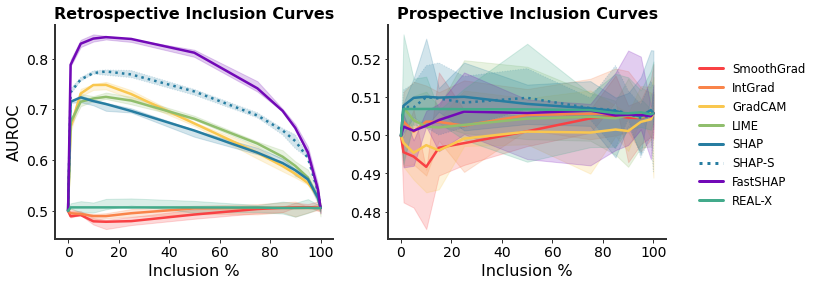

In [44]:
#### FIGURE ####

fig, axs = plt.subplots(1, 2, figsize=(2*6*.8, 1*6*.7), sharex=True)

exp = 'Retinal Fundus Imaging (Permuted)'
exp_result = results[exp]
lines = []
for i, method in enumerate(method_order):
    if (method in methods.keys()) and (method in exp_result.keys()):
        method_result = exp_result[method]
        col = 0
        for metric, metric_result in method_result.items():
            if 'in' in metric:
                #Create DataFrame for Accuracy w/ CI 
                acc_df =  pd.DataFrame([(int(k), metric_result['auroc'][k], 
                                         np.percentile(v, 2.5), np.percentile(v, 97.5)) 
                                        for k, v in metric_result['bootstrap_auroc'].items()])
                acc_df.columns = ['Percent', 'AUROC', 'lower', 'upper']

                # Plot Curve
                line, = axs[col].plot(acc_df['Percent'], acc_df['AUROC'],
                                  label=methods[method], color=colors[methods[method]],
                                  linestyle=line_types[methods[method]])
                if col == 0:
                    lines.append(line)
                axs[col].fill_between(acc_df['Percent'],
                                          acc_df['lower'],
                                          acc_df['upper'],
                                          color=colors[methods[method]], 
                                          linestyle=line_types[methods[method]], 
                                          alpha=0.2)
                col+=1 
    
#Labeling
axs[0].set_title('Retrospective Inclusion Curves', fontsize=16)
axs[1].set_title('Prospective Inclusion Curves', fontsize=16)

axs[0].set_xlabel('Inclusion %', fontsize=16)
axs[1].set_xlabel('Inclusion %', fontsize=16)
axs[0].set_ylabel('AUROC', fontsize=16)

leg = fig.legend(handles = lines, loc='upper center', 
                 bbox_to_anchor=(1.1, .8), frameon=False,
                 fancybox=False, shadow=False, ncol=1, fontsize='small')
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
plt.tick_params(labelsize=14)       

plt.tight_layout()
    
pdf = PdfPages(exp.replace(' ', '_').lower()+'_inclusion_curve.pdf')
pdf.savefig(pad_inches=0, bbox_inches='tight')
pdf.close()

plt.show()